# Herron Topic 3 - Multifactor Models

This notebook covers multifactor models, emphasizing the capital asset pricing model (CAPM) and Fama-French three-factor model (FF3).
Ivo Welch provides a high-level review of the CAPM and multifactor models in [Chapter 12 of his free *Corporate Finance* textbook](https://book.ivo-welch.info/read/source5.mba/10-capm.pdf).
The [Wikipedia page for the CAPM](https://en.wikipedia.org/wiki/Capital_asset_pricing_model) is surprisingly good and includes its assumptions and shortcomings.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%config InlineBackend.figure_format = 'retina'
%precision 4
pd.options.display.float_format = '{:.4f}'.format

## The Capital Asset Pricing Model (CAPM)

The CAPM explains the relation between risk and expected return, and it has applications throughout finance.
We use the CAPM to estimate costs of capital in corporate finance, assemble portfolios with a given risk-return tradeoff in portfolio management, and estimate expected rates of return in investment analysis.
The formula for the CAPM is $E(R_i) = R_F + \beta_i [E(R_M) - R_F]$, where:

1. $R_F$ is the risk-free rate of return,
1. $E(R_M)$ is the expected rate of return on the market, and
1. $\beta_i$ is the market beta for asset $i$.

Here, $\beta_i$ measures asset $i$'s risk exposure or sensitivity to market returns.
The value-weighted mean of $\beta_i$'s is 1 by construction, but a range of values is possible:

1. $\beta_i < -1$: Asset $i$ moves in the opposite direction as the market, in larger magnitudes
1. $-1 \leq \beta_i < 0$: Asset $i$ moves in the opposite direction as the market
1. $\beta_i = 0$: Asset $i$ has no correlation between with the market
1. $0 < \beta_i \leq 1$: Asset $i$ moves in the same direction as the market, in smaller magnitudes
1. $\beta_i = 1$: Asset $i$ moves in the same direction with the same magnitude as the market
1. $\beta_i > 1$: Asset $i$ moves in the same direction as the market, in larger magnitudes

### $\beta$ Estimation

We can use three (equivalent) approaches to estimate $\beta_i$:

1. From covariance and variance as $\beta_i = \frac{Cov(R_i - R_F, R_M - R_F)}{Var(R_M - R_F)}$
1. From correlation and standard deviations as $\beta_i = \rho_{i, M} \cdot \frac{\sigma_i}{\sigma_M}$, where all statistics use *excess* returns (i.e., $R_i-R_F$ and $R_M-R_F$)
1. From a linear regression of $R_i-R_F$ on $R_M-R_F$

The first two approaches are computationally simpler.
However, the third approach also estimates the intercept $\alpha$ and goodness-of-fit statistics.
We can use Apple (AAPL) to convince ourselves these three approaches are equivalent.

In [3]:
import yfinance as yf
import pandas_datareader as pdr
import requests_cache
session = requests_cache.CachedSession()

***Note, we will leave returns in percent to make it easier to interpret our regression output!***

In [4]:
aapl = (
    yf.download(tickers='AAPL', progress=False)
    .assign(
        Date=lambda x: x.index.tz_localize(None),
        Ri=lambda x: x['Adj Close'].pct_change().mul(100)
    )
    .set_index('Date')
    .rename_axis(columns='Variable')
)

In [5]:
ff = (
    pdr.DataReader(
        name='F-F_Research_Data_Factors_daily',
        data_source='famafrench',
        start='1900',
        session=session
    )
)

In [6]:
aapl = (
    aapl
    .join(ff[0])
    .assign(RiRF = lambda x: x['Ri'] - x['RF'])
    .rename(columns={'Mkt-RF': 'MktRF'})
)

#### Covariance and Variance

In [7]:
vcv = aapl[['MktRF', 'RiRF']].dropna().cov()
vcv

,MktRF,RiRF
MktRF,1.2441,1.5706
RiRF,1.5706,7.9996


In [8]:
print(f"Apple beta from cov/var: {vcv.loc['MktRF', 'RiRF'] / vcv.loc['MktRF', 'MktRF']:0.4f}")

Apple beta from cov/var: 1.2625


#### Correlation and Standard Deviations

In [9]:
_ = aapl[['MktRF', 'RiRF']].dropna()
rho = _.corr()
sigma = _.std()
print(f'rho:\n{rho}\n\nsigma:\n{sigma}')

rho:
       MktRF   RiRF
MktRF 1.0000 0.4979
RiRF  0.4979 1.0000

sigma:
MktRF   1.1154
RiRF    2.8284
dtype: float64


In [10]:
print(f"Apple beta from rho and sigmas: {rho.loc['MktRF', 'RiRF'] * sigma.loc['RiRF'] / sigma.loc['MktRF']:0.4f}")

Apple beta from rho and sigmas: 1.2625


#### Linear Regression

Here we need to use the statsmodels package.
I typically use the formula advanced programming interface (API).

In [11]:
import statsmodels.formula.api as smf

With statsmodels (and most model estimations in Python), we have three steps:

1. Specify the model
1. Fit the model
1. Summarize the model

In [12]:
model = smf.ols('RiRF ~ MktRF', aapl)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   RiRF   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     3493.
Date:                Thu, 09 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:49:38   Log-Likelihood:                -24556.
No. Observations:               10602   AIC:                         4.912e+04
Df Residuals:                   10600   BIC:                         4.913e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0520      0.024      2.180      0.029       0.005       0.099
MktRF          1.2625      0.021     59.105      0.000       1.221       1.304
==============================================================================
Omnibus:                     3126.527   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           313355.865
Skew:                          -0.376   Prob(JB):                         0.00
Kurtosis:                      29.623   Cond. No.                         1.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can chain these operations, but it often makes sense to save the intermediate results (i.e., `model` and `fit`).

In [13]:
smf.ols('RiRF ~ MktRF', aapl).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   RiRF   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     3493.
Date:                Thu, 09 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:49:38   Log-Likelihood:                -24556.
No. Observations:               10602   AIC:                         4.912e+04
Df Residuals:                   10600   BIC:                         4.913e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0520      0.024      2.180      0.029       0.005       0.099
MktRF          1.2625      0.021     59.105      0.000       1.221       1.304
==============================================================================
Omnibus:                     3126.527   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           313355.865
Skew:                          -0.376   Prob(JB):                         0.00
Kurtosis:                      29.623   Cond. No.                         1.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### $\beta$ Visualization

We can visualize Apple's $\beta$, using seaborn's `regplot()` to add a best-fit line.

In [14]:
import seaborn as sns

We can write a couple of function to more easily make prettier plots.

In [15]:
def label_beta(x):
    vcv = x.cov()
    beta = vcv.loc['RiRF', 'MktRF'] / vcv.loc['MktRF', 'MktRF']
    return r'$\beta=$' + f'{beta: 0.4f}'

In [16]:
def label_dates(x):
    y = x.dropna()
    return f'from {y.index[0]:%b %d, %Y} to {y.index[-1]:%b %d, %Y}'

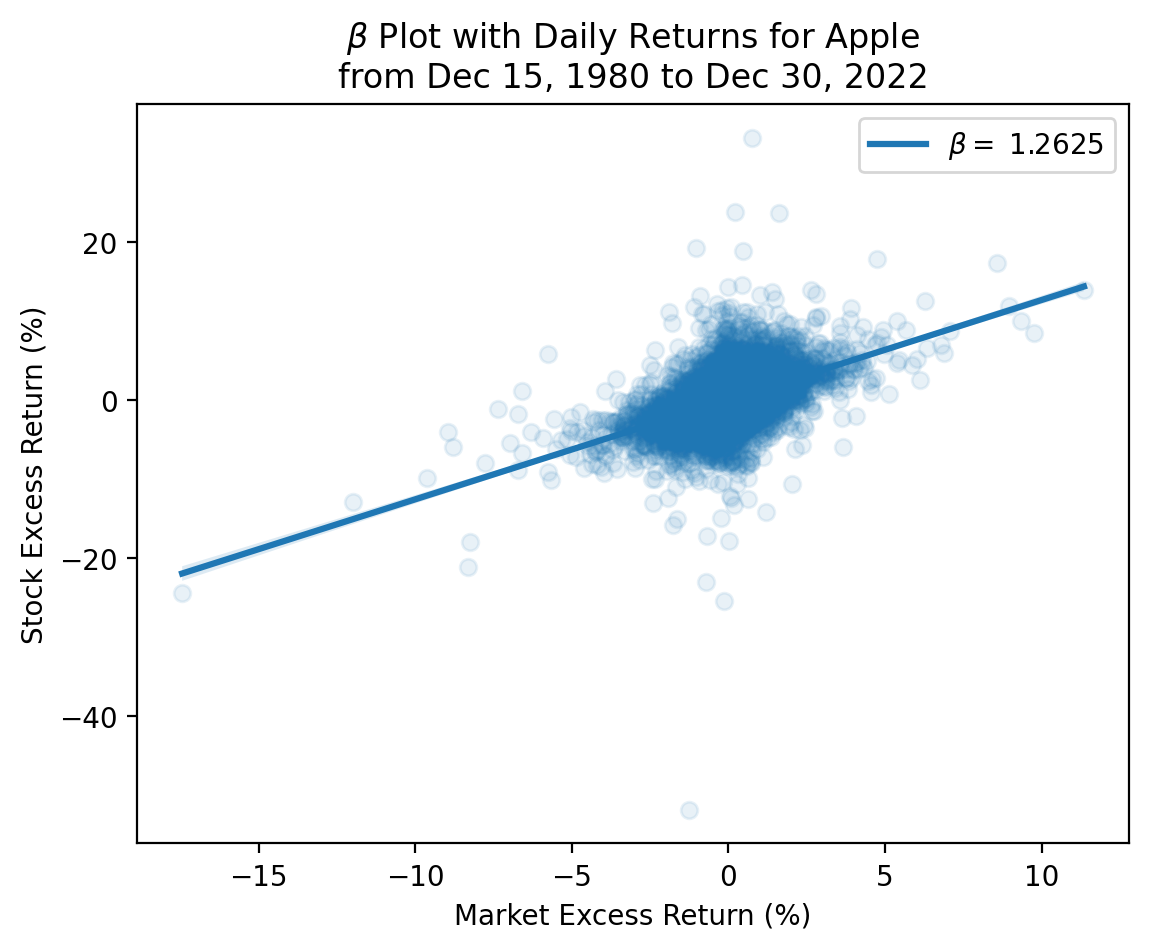

In [17]:
_ = aapl[['MktRF', 'RiRF']].dropna()

sns.regplot(
    x='MktRF',
    y='RiRF',
    data=_,
    scatter_kws={'alpha':0.1},
    line_kws={'label': _.pipe(label_beta)}
)
plt.legend()
plt.xlabel('Market Excess Return (%)')
plt.ylabel('Stock Excess Return (%)')
plt.title(r'$\beta$ Plot with Daily Returns for Apple' + '\n' + _.pipe(label_dates))
plt.show()

We see a strong relation between Apple and market (excess) returns, but there is a lot of unexplained variation in Apple (excess) returns.
The best practice is to estimate $\beta$ with one to three years of daily data.

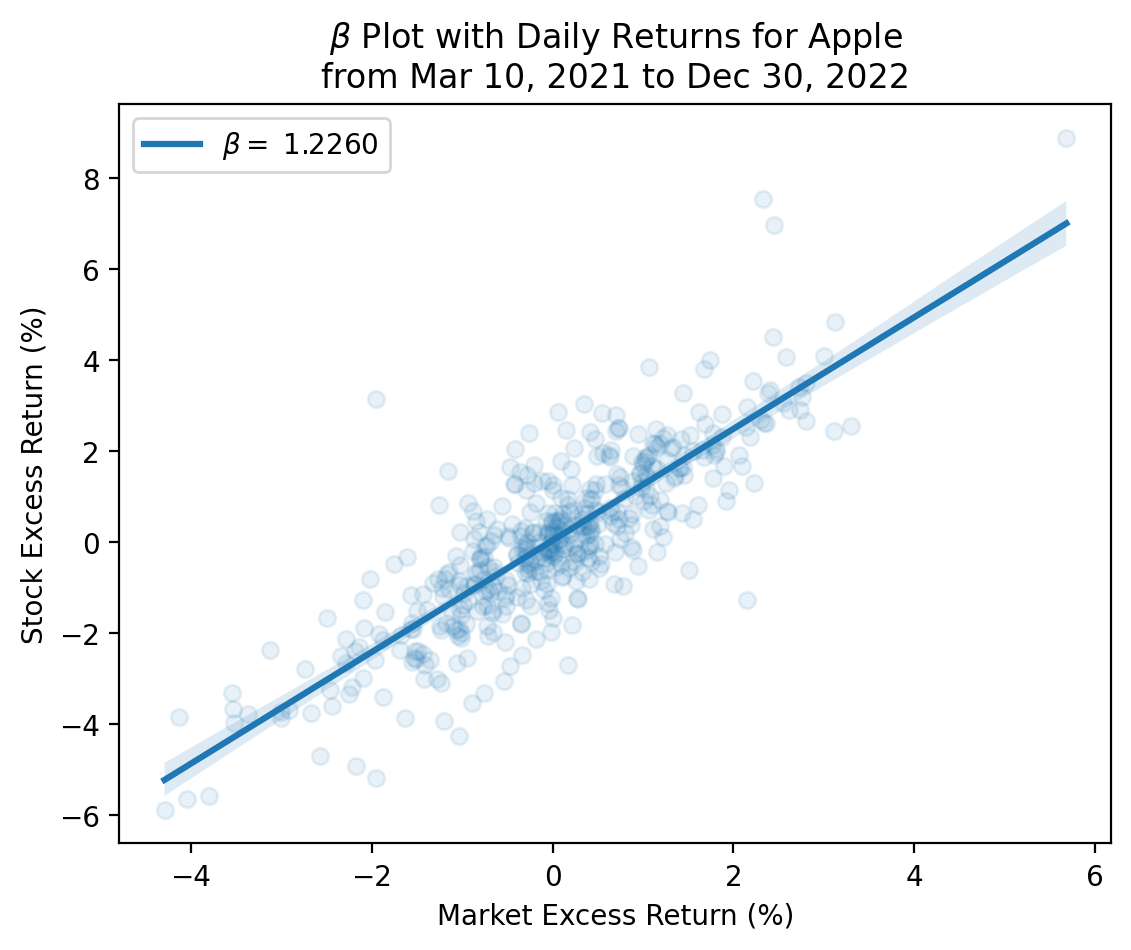

In [18]:
_ = aapl[['MktRF', 'RiRF']].iloc[-504:]

sns.regplot(
    x='MktRF',
    y='RiRF',
    data=_,
    scatter_kws={'alpha':0.1},
    line_kws={'label': _.pipe(label_beta)}
)
plt.legend()
plt.xlabel('Market Excess Return (%)')
plt.ylabel('Stock Excess Return (%)')
plt.title(r'$\beta$ Plot with Daily Returns for Apple' + '\n' + _.pipe(label_dates))
plt.show()

### The Security Market Line (SML)

The SML is a visualization of the CAPM.
We can think of $E(R_i) = R_F +  \beta_i [E(R_M) - R_F]$ as $y = b + mx$, where:

1. The equity premium $E(R_M) - R_F$ is the slope of the SML
1. The risk-free rate of return $R_F$ is its intercept.

We will explore the SML more in the practice notebook.

### How well does the CAPM work?

The CAPM *appears* to work well as a single-period model.
We can see this with portfolios formed on $\beta$ from Ken French.

In [19]:
ff_beta = pdr.DataReader(
    name='Portfolios_Formed_on_BETA',
    data_source='famafrench',
    start='1900',
    session=session
)

In [20]:
print(ff_beta['DESCR'])

Portfolios Formed on BETA
-------------------------

This file was created by CMPT_BETA_RETS using the 202301 CRSP database. It contains value- and equal-weighted returns for portfolios formed on BETA. The portfolios are constructed at the end of June. Beta is estimated using monthly returns for the past 60 months (requiring at least 24 months with non-missing returns). Beta is estimated using the Scholes-Williams method. Annual returns are from January to December. Missing data are indicated by -99.99 or -999. The break points include utilities and include financials. The portfolios include utilities and include financials. Copyright 2023 Kenneth R. French

  0 : Value Weighted Returns -- Monthly (715 rows x 15 cols)
  1 : Equal Weighted Returns -- Monthly (715 rows x 15 cols)
  2 : Value Weighted Returns -- Annual from January to December (59 rows x 15 cols)
  3 : Equal Weighted Returns -- Annual from January to December (59 rows x 15 cols)
  4 : Number of Firms in Portfolios (715 ro

This file contains seven data frames.
We want the data frame at `[2]`, which contains the annual returns on two sets of portfolios formed on the previous year's $\beta$.

In [21]:
ff_beta[2].head()

,Lo 20,Qnt 2,Qnt 3,Qnt 4,Hi 20,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10
Date,,,,,,,,,,,,,,,
1964,16.8700,19.7500,17.6600,8.7300,12.5500,24.7000,13.5900,20.2700,19.0100,19.7900,15.6800,9.7900,8.2300,13.6000,11.6600
1965,8.7200,6.9800,15.4000,24.8800,49.6700,12.4400,6.7600,10.0200,5.2500,13.7100,17.1100,20.7000,28.2800,42.0700,57.7300
1966,-9.2500,-12.1700,-9.1000,-2.7300,-2.2000,-9.4300,-9.4400,-12.5700,-12.1600,-7.5000,-10.5600,-6.2200,0.1800,-3.3100,-0.9400
1967,13.4300,22.0600,31.9500,42.7900,51.1500,8.9200,18.6400,22.7900,21.6500,31.1100,34.1600,40.5700,44.4000,41.6100,59.7800
1968,15.8100,9.1200,13.6400,14.4300,24.2400,18.4800,12.8400,14.5100,5.8400,12.6600,14.7500,19.0800,10.5400,23.2500,25.2900


We can plot the mean annual return on each of the five portfolios in the first set of portflios.

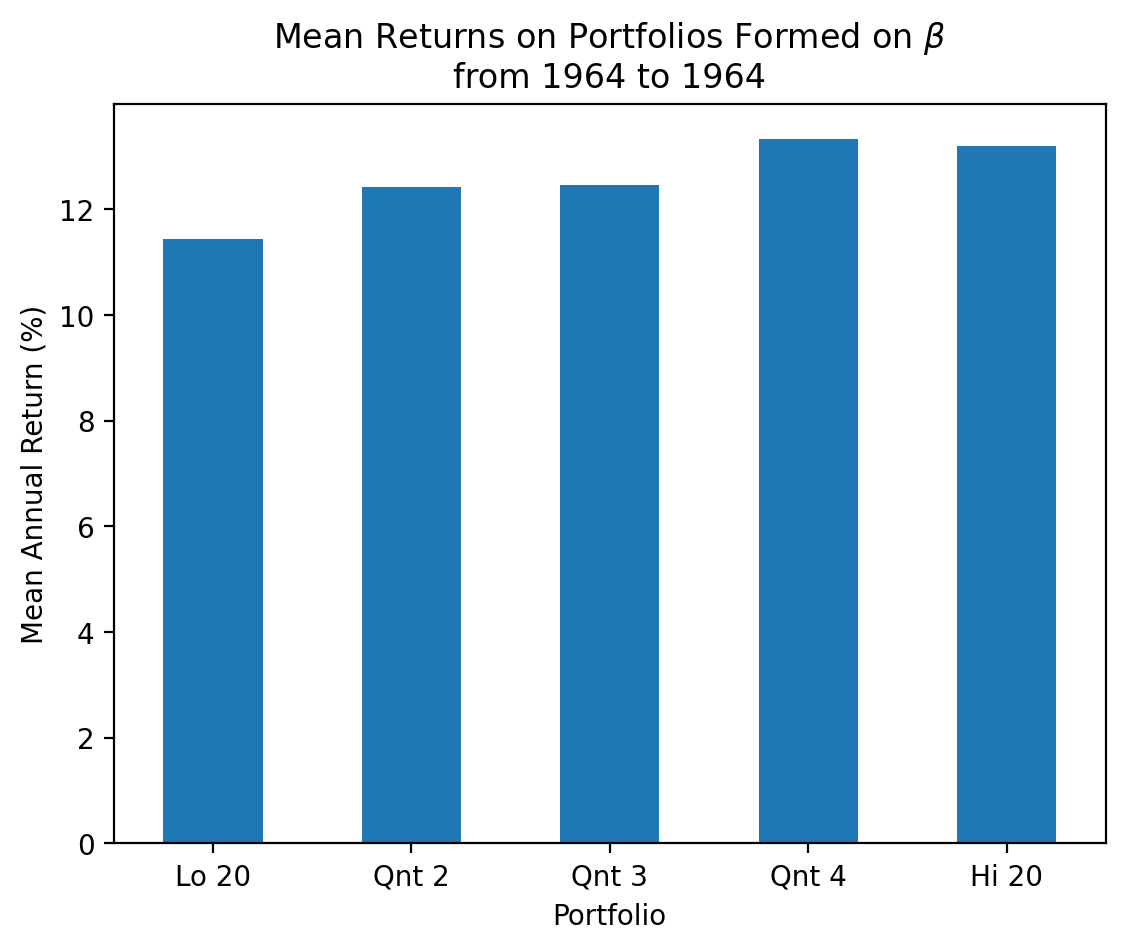

In [22]:
_ = ff_beta[2].iloc[:, :5]
_.mean().plot(kind='bar')
plt.ylabel('Mean Annual Return (%)')
plt.xlabel('Portfolio')
plt.xticks(rotation=0)
plt.title(r'Mean Returns on Portfolios Formed on $\beta$' + '\n' + f'from {_.index[0]} to {_.index[0]}')
plt.show()

We can think of the plot above as a binned plot of the SML.
The x axis above is an ordinal measure of $\beta$, and the y axis above is the mean return.
Recall the slope of the SML is the market risk premium.
If the market risk premium is too low, then high $\beta$ stocks do not have high enough returns.
We can see this failure of the CAPM by plotting long-term or cumulative returns on these five portfolios.

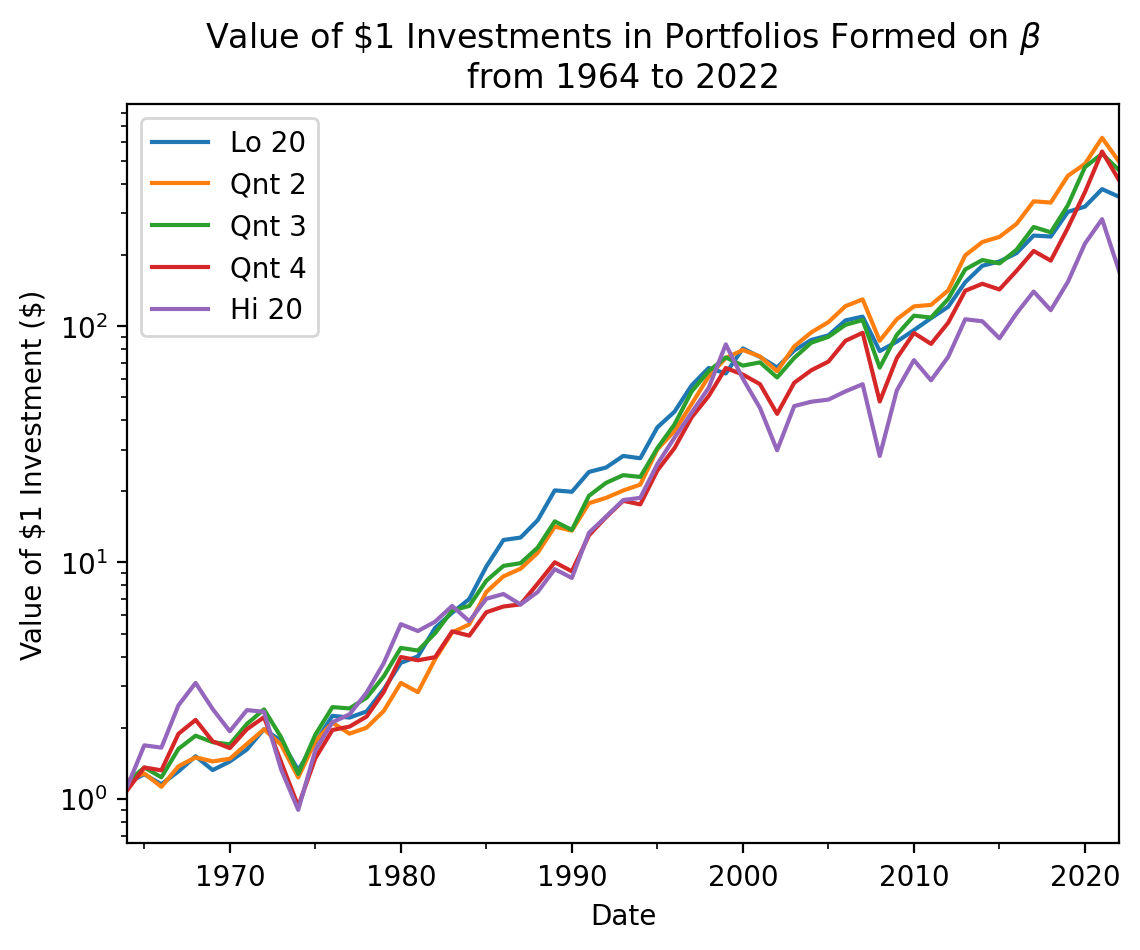

In [23]:
_ = ff_beta[2].iloc[:, :5]
_.div(100).add(1).cumprod().plot()
plt.semilogy()
plt.ylabel('Value of \$1 Investment (\$)')
plt.title(r'Value of \$1 Investments in Portfolios Formed on $\beta$' + '\n' + f'from {_.index[0]} to {_.index[-1]}')
plt.show()

In the plot above, the high $\beta$ portfolio has the lowest cumulative returns!
The log scale masks a lot of variation, too!

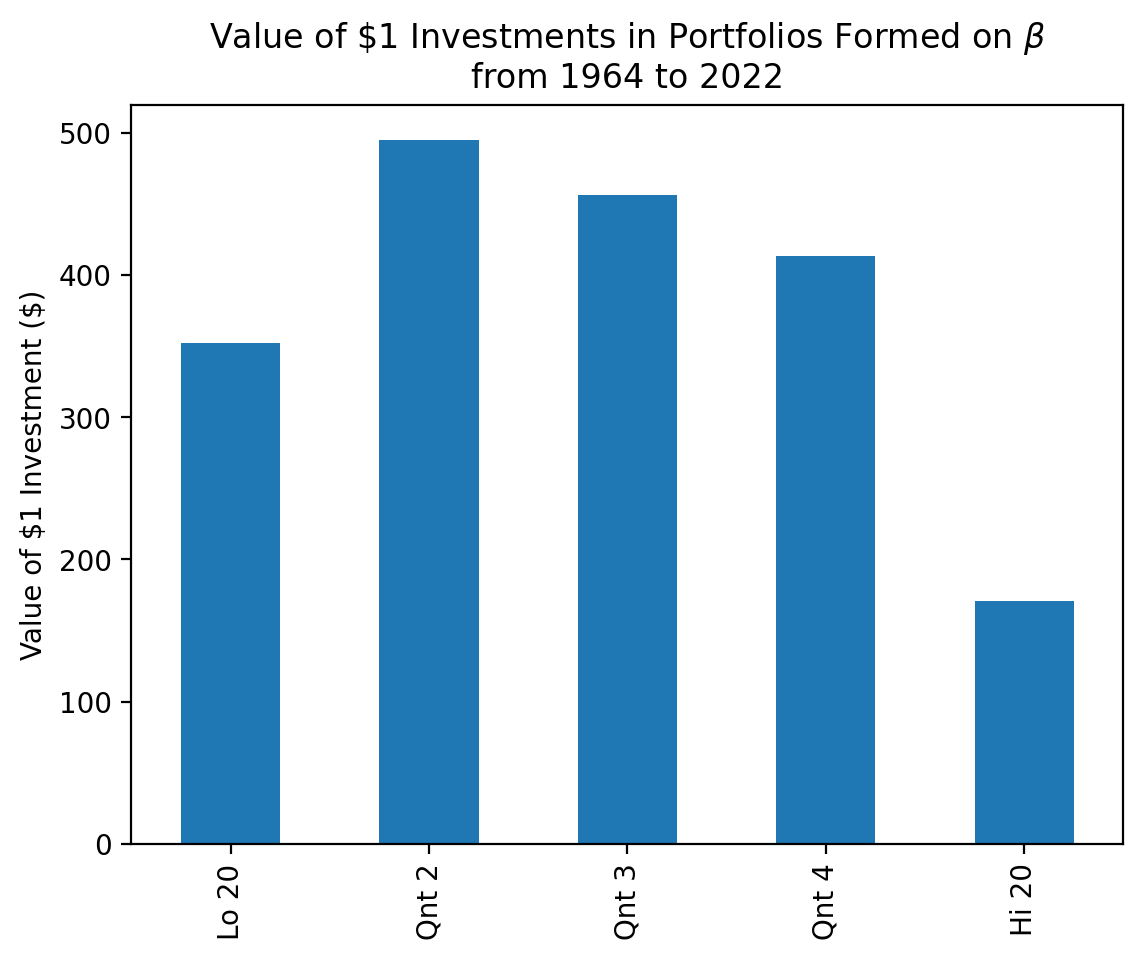

In [24]:
_ = ff_beta[2].iloc[:, :5]
_.div(100).add(1).prod().plot(kind='bar')
plt.ylabel('Value of \$1 Investment (\$)')
plt.title(r'Value of \$1 Investments in Portfolios Formed on $\beta$' + '\n' + f'from {_.index[0]} to {_.index[-1]}')
plt.show()

If the CAPM does not work well, especially over the horizons we use it for (e.g., capital budgeting), why do we continue to learn it?

1. The CAPM works well *across* asset classes. We will explore this more in the practice notebook.
1. The CAPM intuition that diversification matters is correct and important
1. The CAPM assigns high costs of capital to high-$\beta$ projects (i.e., high-risk projects), which could be considered a feature instead of a bug
1. In practice, everyone uses the CAPM

Ivo Welch provides a more complete discussion in section 10.5 of [chapter 10 of this his free *Corporate Finance* textbook](https://book.ivo-welch.info/read/source5.mba/10-capm.pdf).

## Multifactor Models

Another shortcoming of the CAPM is that it fails to explain the returns on portfolios formed on size (market capitalization) and value (book-to-market equity ratio), which we will explore in the practice notebook.
These shortcomings have led to an explosion in multifactor models, which we will explore here.

### The Fama-French Three-Factor Model

Fama and French (1993) expand the CAPM by adding two additional factors to explain the excess returns on size and value.
The size factor, SMB or small-minus-big, is a diversified portfolio that measures the excess returns of  small market cap. stocks over large market cap. stocks.
The value factor, HML of high-minus-low, is a diversified portfolio that measures the excess returns of high book-to-market stocks over low  high book-to-market stocks.
We typically call this model the "Fama-French three-factor model" and express it as: $E(R_i) = R_F + \alpha + \beta_{M} [E(R_M) - R_M)] + \beta_{SMB} SMB + \beta_{HML} HML$.
There are two common uses for the three-factor model:

1. Use the coefficient estimate on the intercept (i.e., $\alpha$,  often called "Jensen's $\alpha$") as a risk-adjusted performance measure. If $\alpha$ is positive and statistically significant, we may attribute fund performance to manager skill.
2. Use the remaining coefficient estimates to evaluate how the fund manager generates returns. If the regression $R^2$ is high, we may replace the fund manager with the factor itself.

We can use the Fama-French three-factor model to evaluate Warren Buffett at Berkshire Hathaway (BRK-A).

In [25]:
brk = (
    yf.download(tickers='BRK-A', progress=False)
    .assign(
        Date=lambda x: x.index.tz_localize(None),
        Ri=lambda x: x['Adj Close'].pct_change().mul(100)
    )
    .set_index('Date')
    .join(ff[0])
    .assign(RiRF = lambda x: x['Ri'] - x['RF'])
    .rename(columns={'Mkt-RF': 'MktRF'})
    .rename_axis(columns='Variable')
)

In [26]:
model = smf.ols(formula='RiRF ~ MktRF + SMB + HML', data=brk.iloc[:756])
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   RiRF   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     13.91
Date:                Thu, 09 Mar 2023   Prob (F-statistic):           7.81e-09
Time:                        16:49:39   Log-Likelihood:                -1208.9
No. Observations:                 755   AIC:                             2426.
Df Residuals:                     751   BIC:                             2444.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0801      0.044      1.809      0.071      -0.007       0.167
MktRF          0.3484      0.075      4.643      0.000       0.201       0.496
SMB            0.4021      0.093      4.302      0.000       0.219       0.586
HML            0.0907      0.125      0.724      0.469      -0.155       0.336
==============================================================================
Omnibus:                      118.864   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1308.034
Skew:                           0.284   Prob(JB):                    9.20e-285
Kurtosis:                       9.423   Cond. No.                         3.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The $\alpha$ above seems small, but this is a *daily* value.
We can multiple $\alpha$ by 252 to annualize it.

In [27]:
print(f"Buffet's annualized alpha in the early 1980s: {fit.params['Intercept'] * 252: 0.4f}")

Buffet's annualized alpha in the early 1980s:  20.1836


We will explore rolling $\alpha$s and $\beta$s in the practice notebook using `RollingOLS()` from `statsmodels.regression.rolling`. 

### The Four-Factor and Five-Factor Models

There are literally hundreds of published factors!
However, many of them have little explanatory power, in or out of sample.
Two more factor models that have explanatory power, economic intuition, and widespread adoption are the four-factor model and five-factor model.


The four-factor model adds a momentum factor to the Fama-French three-factor model.
The momentum factor is a diversified portfolio that measures the excess returns of winner stocks over the loser stocks over the past 12 months.
The momentum factor is often called UMD for up-minus-down or WML for winners-minus-losers.
French stores the momentum factor in a different file because Fama and French are skeptical of momentum as a foundational risk factor.


The five -factor model adds profitability and investment policy factors.
The profitability factor, RMW or robust-minus-weak, measures the excess returns of stocks with high profits over those with low profits.
The investment policy factor, CMA or conservative-minus-aggressive, measures the excess returns of stocks with low corporate investment (conservative) over those with high corporate investment (aggressive).


We will explore the four-factor and five-factor models in the practice notebook.